In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import polars as pl
import re
import nltk

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words("english"))
def fast_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|[^a-zA-Z\s]", "", text)
    tokens = re.findall(r'\b\w+\b', text)
    return " ".join([t for t in tokens if t not in stop_words])

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
import datasets
from datasets import load_dataset

In [ ]:
dataset = load_dataset("artem9k/ai-text-detection-pile")['train']
texts, labels, seen = [], [], set()
for sample in dataset:
    raw = sample["text"]
    if raw and raw.strip():
        cleaned = fast_clean(raw)
        if cleaned and cleaned not in seen:
            seen.add(cleaned)
            texts.append(cleaned)
            labels.append(1 if sample["source"] == "ai" else 0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

(…)-00000-of-00007-bc5952582e004d67.parquet:   0%|          | 0.00/758M [00:00<?, ?B/s]

(…)-00001-of-00007-71c80017bc45f30d.parquet:   0%|          | 0.00/318M [00:00<?, ?B/s]

(…)-00002-of-00007-ee2d43f396e78fbc.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

(…)-00003-of-00007-529931154b42b51d.parquet:   0%|          | 0.00/137M [00:00<?, ?B/s]

(…)-00004-of-00007-b269dc49374a2c0b.parquet:   0%|          | 0.00/137M [00:00<?, ?B/s]

(…)-00005-of-00007-3dce5e05ddbad789.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

(…)-00006-of-00007-3d8a471ba0cf1c8d.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1392522 [00:00<?, ? examples/s]

In [ ]:
import matplotlib.pyplot as plt
import re, random
from collections import Counter

In [ ]:
def plot_distribution(labels, title):
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n {title}")
    print(f"Total samples: {total}")
    for label in sorted(counter):
        name = "Human" if label == 0 else "AI"
        print(f"Label {label} ({name}): {counter[label]} samples")

    plt.figure(figsize=(6, 4))
    plt.bar(counter.keys(), counter.values(), tick_label=["Human", "AI"], color=["skyblue", "salmon"])
    plt.title(f"{title} (Total: {total})")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


 Before Balancing
Total samples: 1383924
Label 0 (Human): 1022486 samples
Label 1 (AI): 361438 samples


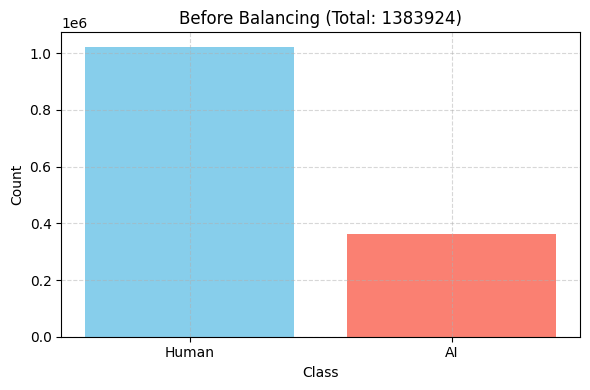

In [ ]:
plot_distribution(labels, "Before Balancing")

In [ ]:
ai_texts = [t for t, l in zip(texts, labels) if l == 1]
human_texts = [t for t, l in zip(texts, labels) if l == 0]
min_len = min(len(ai_texts), len(human_texts))
ai_texts = random.sample(ai_texts, min_len)
human_texts = random.sample(human_texts, min_len)

balanced_texts = ai_texts + human_texts
balanced_labels = [1]*min_len + [0]*min_len
combined = list(zip(balanced_texts, balanced_labels))
random.shuffle(combined)
balanced_texts, balanced_labels = zip(*combined)


 After Balancing
Total samples: 722876
Label 0 (Human): 361438 samples
Label 1 (AI): 361438 samples


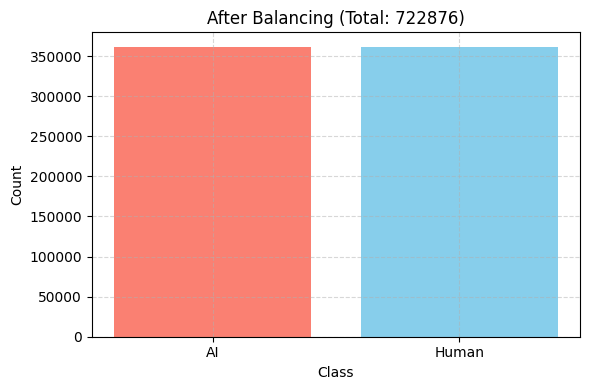

In [ ]:
plot_distribution(balanced_labels, "After Balancing")

In [ ]:
df = pl.DataFrame({"text": balanced_texts, "label": balanced_labels})

In [ ]:
X_train_text, X_val_text, y_train, y_val = train_test_split(
    df["text"].to_list(), df["label"].to_list(), test_size=0.2, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

In [ ]:
svd = TruncatedSVD(n_components=1000)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_val_reduced = svd.transform(X_val_tfidf)

In [ ]:
X_train_seq = X_train_reduced.reshape(X_train_reduced.shape[0], 10, 100)
X_val_seq = X_val_reduced.reshape(X_val_reduced.shape[0], 10, 100)

In [ ]:
import numpy as np
X_train_seq, X_val_seq = np.array(X_train_seq), np.array(X_val_seq)
y_train, y_val = np.array(y_train), np.array(y_val)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dense, Dropout

def get_lstm_model(input_shape=(10, 100)):
    return Sequential([
        LSTM(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [ ]:
def get_bilstm_model(input_shape=(10, 100)):
    return Sequential([
        Bidirectional(LSTM(64), input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [ ]:
def get_gru_model(input_shape=(10, 100)):
    return Sequential([
        GRU(64, input_shape=input_shape),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

def train_and_evaluate(model, name):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    model.fit(
        X_train_seq, y_train,
        validation_data=(X_val_seq, y_val),
        epochs=7,
        batch_size=64,
        callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
        verbose=1
    )

    y_pred = (model.predict(X_val_seq) > 0.5).astype("int32")
    print(f"\n{name} Classification Report:")
    print(classification_report(y_val, y_pred))

In [ ]:
train_and_evaluate(get_lstm_model(), "LSTM")
train_and_evaluate(get_bilstm_model(), "BiLSTM")
train_and_evaluate(get_gru_model(), "GRU")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,353 (173.25 KB)

 Trainable params: 44,353 (173.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - accuracy: 0.8194 - loss: 0.3897 - val_accuracy: 0.8806 - val_loss: 0.2742
Epoch 2/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.8804 - loss: 0.2738 - val_accuracy: 0.8885 - val_loss: 0.2570
Epoch 3/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.8900 - loss: 0.2526 - val_accuracy: 0.8961 - val_loss: 0.2412
Epoch 4/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - accuracy: 0.8954 - loss: 0.2414 - val_accuracy: 0.8996 - val_loss: 0.2342
Epoch 5/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.8992 - loss: 0.2335 - val_accuracy: 0.9008 - val_loss: 0.2309
Epoch 6/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.9020 - loss: 0.2282 - val_accuracy: 0.9032 - val_loss: 0.2244
Epoch 7/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - accuracy: 0.9034 - loss: 0.2247 - val_accuracy: 0.9007 - val_loss: 0.2270
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

LSTM Classification Report:
              prec

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,641 (346.25 KB)

 Trainable params: 88,641 (346.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 62s 7ms/step - accuracy: 0.8331 - loss: 0.3675 - val_accuracy: 0.8863 - val_loss: 0.2631
Epoch 2/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.8859 - loss: 0.2618 - val_accuracy: 0.8991 - val_loss: 0.2338
Epoch 3/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - accuracy: 0.8984 - loss: 0.2362 - val_accuracy: 0.9006 - val_loss: 0.2340
Epoch 4/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.9036 - loss: 0.2241 - val_accuracy: 0.8986 - val_loss: 0.2356
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step

BiLSTM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90     72414
           1       0.89      0.92      0.90     72162

    accuracy                           0.90    144576
   macro avg       0.90      0.90      0.90    144576
weighted avg       0.90      0.90      0.90    144576



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,985 (132.75 KB)

 Trainable params: 33,985 (132.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - accuracy: 0.7913 - loss: 0.4140 - val_accuracy: 0.8740 - val_loss: 0.2832
Epoch 2/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.8766 - loss: 0.2785 - val_accuracy: 0.8907 - val_loss: 0.2529
Epoch 3/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.8912 - loss: 0.2498 - val_accuracy: 0.8926 - val_loss: 0.2441
Epoch 4/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.8958 - loss: 0.2405 - val_accuracy: 0.8957 - val_loss: 0.2406
Epoch 5/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.9003 - loss: 0.2310 - val_accuracy: 0.9017 - val_loss: 0.2290
Epoch 6/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.9029 - loss: 0.2256 - val_accuracy: 0.9047 - val_loss: 0.2212
Epoch 7/7
9036/9036 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.9064 - loss: 0.2193 - val_accuracy: 0.9078 - val_loss: 0.2164
4518/4518 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

GRU Classification Report:
              preci